Übung 3.2 a) Ziel dieser Aufgabe ist es den kostenminimalen Kraftwerkseinsatz und die Stromversorgungskosten sowie die Gesamtemissionen zu ermittelt. Im Gegensatz zu 3.1 wird nun aber die erneuerbare Erzeugung aus Wind und PV inkludiert. Speicher werden in dieser Aufgabe weiterhin nicht berücksichtigt. Der Priority-Feed-In der Erneuerbaren wurde beachtet. 

In [6]:
#Einlesen der Module
from pyomo.environ import *
import pyomo.environ as pyo
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


T = 24
timesteps = np.arange(T)

#Zertifikatspreis
c_CO2 = 30 # EUR/tCO2

# Marginal costs der thermischen Kraftwerke berechnen
# Werte wurden auf die Angabe angepasst
thermalPlant = ['Kohle', 'GuD', 'Gasturbine']
power = {'Kohle': 600,
         'GuD': 400,
         'Gasturbine': 300} # MW
efficiency = {'Kohle': 0.41,
         'GuD': 0.58,
         'Gasturbine': 0.4} 
fuel_price = {'Kohle': 10,
         'GuD': 30,
         'Gasturbine': 30} # EUR/MWhprim
emission_factor = {'Kohle': 0.35,
         'GuD': 0.2,
         'Gasturbine': 0.2} # tCO2/MWhprim
MC = {} # marginal costs in EUR/MWh
emissions = {} # emissions in tCO2/MWh
for n in thermalPlant:
    MC[n] = (fuel_price[n] + emission_factor[n] * c_CO2) / efficiency[n]
    emissions[n] = emission_factor[n] / efficiency[n]
    
# Daten laden, PV und Wind laden
df = pd.read_excel('Last_PV_Wind.xlsx')
wind = df['Wind 300 MW']
PV = df['PV 200 MW Sommer']
load = df['Last Sommer [MW]']-df['Wind 300 MW']-df['PV 200 MW Sommer'] # Gruppe 3
#print(load)
#die Residuallast (in unserem Fall mit load definiert) entspricht der gesamten Nachfrage minus der Erzeugung aus PV und minus der Erzeugung aus Wind
#Residuallast muss von thermischen Kraftwerken gedeckt werden 

# Pyomo Modell aufstellen

model = ConcreteModel()

model.x = Var(thermalPlant, timesteps, within = NonNegativeReals)

# Zielfunktion, Kosten sollen minimiert werden
#dazu werden die Grenzkosten aller Kraftwerke zu jedem timestep summiert.
model.obj = Objective(
    expr = sum(model.x[n,t] * MC[n] for n in thermalPlant for t in timesteps), 
    sense= minimize)

#Nebenbedingungen bezüglich Leistung und Last 
def power_constraint_rule(model, n, t):    
   return model.x[n,t] <= power[n]
model.power_con = Constraint(thermalPlant, 
                             timesteps, 
                             rule = power_constraint_rule)

def load_constraint_rule(model, t):    
   return sum(model.x[n,t] for n in thermalPlant) == load.loc[t]
model.load_con = Constraint(timesteps, 
                            rule = load_constraint_rule)

###Schattenvariable für Punkt c)###
model.dual = pyo.Suffix(direction=pyo.Suffix.IMPORT_EXPORT)

opt = SolverFactory('gurobi')
opt_success = opt.solve(model)

model.display()

# get values of optimization variables
PowerThermal = pd.DataFrame(index = timesteps, columns = thermalPlant)
guDPower = np.empty(T, dtype=float)
gasPower = np.empty(T, dtype=float)
kohlePower = np.empty(T, dtype=float)
for t in timesteps:
    for n in thermalPlant:
        PowerThermal.loc[t, n] = model.x[n,t].value
        guDPower[t] = PowerThermal.loc[t, 'GuD']
        gasPower[t] = PowerThermal.loc[t, 'Gasturbine']
        kohlePower[t] = PowerThermal.loc[t, 'Kohle']

#Berechnung der minimalen Kosten und der gesamten Emissionen
print()
totalMinCost = model.obj()
print("Gesamtkosten der Stromversorgung:", totalMinCost, "EUR" )
totalEmissions = sum(model.x[n,t].value * emissions[n] for n in thermalPlant for t in timesteps)
print("Gesamte CO2 Emissionen", totalEmissions, "tCO2" )

Model unknown

  Variables:
    x : Size=72, Index={Kohle, GuD, Gasturbine}*{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23}
        Key                : Lower : Value              : Upper : Fixed : Stale : Domain
         ('Gasturbine', 0) :     0 :                0.0 :  None : False : False : NonNegativeReals
         ('Gasturbine', 1) :     0 :                0.0 :  None : False : False : NonNegativeReals
         ('Gasturbine', 2) :     0 :                0.0 :  None : False : False : NonNegativeReals
         ('Gasturbine', 3) :     0 :                0.0 :  None : False : False : NonNegativeReals
         ('Gasturbine', 4) :     0 :                0.0 :  None : False : False : NonNegativeReals
         ('Gasturbine', 5) :     0 :                0.0 :  None : False : False : NonNegativeReals
         ('Gasturbine', 6) :     0 :                0.0 :  None : False : False : NonNegativeReals
         ('Gasturbine', 7) :     0 :                0.0

b) Grafische Darstellung der Situation

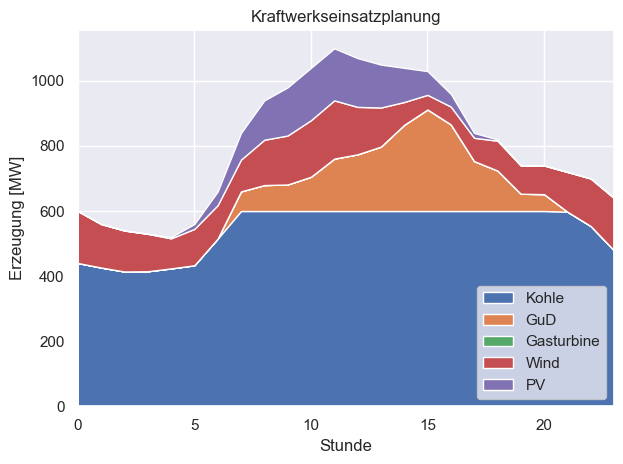

In [7]:
# plot

# plot
sns.set()
labels = ['Kohle', 'GuD', 'Gasturbine','Wind', 'PV']

fig, ax = plt.subplots()

ax.stackplot(timesteps, 
            PowerThermal.to_numpy(dtype = float).transpose(),
             wind, PV,
             labels=labels)
ax.set_title('Kraftwerkseinsatzplanung')
ax.legend(loc='lower right')
ax.set_ylabel('Erzeugung [MW]')
ax.set_xlabel('Stunde')
ax.set_xlim(xmin=timesteps[0], xmax=timesteps[-1])
fig.tight_layout()

In der Grafik ist ersichtlich, dass die Erzeugung von Wind den ganzen Tag über relativ konstant verteilt ist. Wie zu erwarten ist die Erzeugung durch PV nur während dem Tag mit der höchsten Erzeugung während der Mittagszeit. Die Residuallast wird durch die Erzeugung von Kohle und Gas und Dampfmaschien gedeckt. Es wird keine Gasturbine mehr benötigt um die Last zu decken, sie wird von der Erzeugung durch Erneuerbare verdrängt. 

c) Nun sollen die stündlichen Strompreise berechnet werden. Die Berechnung wurde mithilfe der Schattenvariable durchgeführt und mithilfe der kurzfristigen Grenzkosten verifiziert.

In [8]:
print("Wert der Schattenvariable [EUR/MWh]:")
for t in timesteps:
    print("Stunde", t+1, ":", model.dual[model.load_con[t]])

Wert der Schattenvariable [EUR/MWh]:
Stunde 1 : 50.0
Stunde 2 : 50.0
Stunde 3 : 50.0
Stunde 4 : 50.0
Stunde 5 : 50.0
Stunde 6 : 50.0
Stunde 7 : 50.0
Stunde 8 : 62.06896551724138
Stunde 9 : 62.06896551724138
Stunde 10 : 62.06896551724138
Stunde 11 : 62.06896551724138
Stunde 12 : 62.06896551724138
Stunde 13 : 62.06896551724138
Stunde 14 : 62.06896551724138
Stunde 15 : 62.06896551724138
Stunde 16 : 62.06896551724138
Stunde 17 : 62.06896551724138
Stunde 18 : 62.06896551724138
Stunde 19 : 62.06896551724138
Stunde 20 : 62.06896551724138
Stunde 21 : 62.06896551724138
Stunde 22 : 50.0
Stunde 23 : 50.0
Stunde 24 : 50.0


In [9]:
print("Grenzkosten der Kraftwerke:")
print(MC)
print()
print("Strompreis [EUR/MWh]:")
for t in timesteps:
    maxMC=0
    for n in thermalPlant:
        if model.x[n,t].value > 0:
            if MC[n] > maxMC:
                maxMC=MC[n]
    print("Stunde", t+1, ":" ,maxMC)

Grenzkosten der Kraftwerke:
{'Kohle': 50.0, 'GuD': 62.06896551724138, 'Gasturbine': 90.0}

Strompreis [EUR/MWh]:
Stunde 1 : 50.0
Stunde 2 : 50.0
Stunde 3 : 50.0
Stunde 4 : 50.0
Stunde 5 : 50.0
Stunde 6 : 50.0
Stunde 7 : 50.0
Stunde 8 : 62.06896551724138
Stunde 9 : 62.06896551724138
Stunde 10 : 62.06896551724138
Stunde 11 : 62.06896551724138
Stunde 12 : 62.06896551724138
Stunde 13 : 62.06896551724138
Stunde 14 : 62.06896551724138
Stunde 15 : 62.06896551724138
Stunde 16 : 62.06896551724138
Stunde 17 : 62.06896551724138
Stunde 18 : 62.06896551724138
Stunde 19 : 62.06896551724138
Stunde 20 : 62.06896551724138
Stunde 21 : 62.06896551724138
Stunde 22 : 50.0
Stunde 23 : 50.0
Stunde 24 : 50.0


Es ist ersichtlich, dass zu jeder Stunde das Kohlekraftwerk das preissetzende Kraftwerk ist. Der Strompreis, welcher zuvor in Punkt 3.1 während 11 und 16 Uhr aufgrund der Erzeugung durch die Gasturbine erhöht war ist mit hinzufügen der Erzeugung der Erneuerbaren während dieser Zeit gesunken. 